# KNN Recommender System

In this notebook, I will work through the application of KNN to recommendation. This implmentation will fall within the scope of collaborative filtering. I will make use of the MovieLens ml-25m dataset. 

The dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 25000095 ratings and 1093360 tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.


Reference:

* F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

In [1]:
## imports ##
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from typing import Dict

## Load and Preprocess Data Files

The data are contained in files 'genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv' and 'tags.csv'. Let's load these into our notebook:

In [2]:
# load in data
dfRatings = pd.read_csv('./ml-25m/ratings.csv')
dfTags    = pd.read_csv('./ml-25m/tags.csv')
dfMovies  = pd.read_csv('./ml-25m/movies.csv')
dfLinks   = pd.read_csv('./ml-25m/links.csv')
dfGscores = pd.read_csv('./ml-25m/genome-scores.csv')
dfGtags   = pd.read_csv('./ml-25m/genome-tags.csv')

In a previous article on *data pipelines*, we already constructed a set of stage functions for all the preprocessing steps. Let's implement them below, and prepare the data:

In [3]:
## pipeline stages ##
def prepare_ratings(dfRatings: pd.DataFrame) -> pd.DataFrame:
    """
    function to preprocess ratings dataframe
    
    Inputs:
        dfRatings -> dataframe containing ratings information
        
    Outputs:
        ratings dataframe without timestamp column 
    """
    dfRatings.drop(['timestamp'],axis=1,inplace=True)
    return dfRatings

def prepare_tags(dfRatings: pd.DataFrame,
                 dfTags: pd.DataFrame, 
                 dfGtags: pd.DataFrame, 
                 dfGscores: pd.DataFrame, 
                 threshold: float) -> pd.DataFrame:
    """
    function to execute preprocessing on the tags dataframes
    
    Inputs:
        dfRatings -> dataframe containing ratings information
        dfTags    -> dataframe containing tags information
        dfGtags   -> dataframe containing tag genome information
        dfGscores -> dataframe containing tag relevance information
        thresold  -> cutoff threshold based upon tag popularity
        
    Output:
        dataframe containing the prepared tags features merged to dfRatings
    """
    # drop timestamp column
    dfTags.drop(['timestamp'],axis=1,inplace=True)
    
    # set tags to lower case
    dfTags['tag'] = dfTags.tag.str.lower()
    dfGtags['tag'] = dfGtags.tag.str.lower()

    # join dfTags, dfGtags, & dfGscores
    dfTagScores = pd.merge(dfTags,dfGtags,on='tag')
    dfTagScores = pd.merge(dfTagScores,dfGscores,on=['movieId','tagId'])
    
    # extract usable tagId's based on cutoff threshold
    dfTagIds = dfTagScores[['userId','tagId']].copy()
    dfTagIds.drop_duplicates(inplace=True)
    dfTagIds['occurance'] = 1
    sTagIds = dfTagIds.groupby(by=['tagId'])['occurance'].sum().sort_values(ascending=False)
    tagIds = sTagIds[:threshold].index
    
    # OHE the tags, then multiply in the relevance
    sTags = dfTagScores[dfTagScores.tagId.isin(tagIds)].tag
    dfOHE = pd.get_dummies(sTags)
    dfTagsOHE = dfOHE.mul(dfTagScores.relevance,axis=0)
    
    # do final assembly of tags dataframe
    dfTags = pd.concat([dfTagScores[['userId','movieId','tagId']],dfTagsOHE],axis=1)
    
    # return merged results
    return pd.merge(dfRatings,dfTags,on=['userId','movieId'])

def prepare_movies(dfRatings: pd.DataFrame,
                   dfMovies: pd.DataFrame) -> pd.DataFrame:
    """
    function to execute preprocessing on the movies dataframe
    
    Inputs:
        dfRatings -> dataframe containing ratings information
        dfMovies  -> dataframe containing movies-genre information
        
    Output:
        dataframe containing the prepared movies-genre features merged to dfRatings
    """
    # helper function for use when creating genre features
    def flag_genre(row):
        applicable_genres = row['genres'].split('|')
        for genre in applicable_genres:
            row[genre] = 1
        return row
    
    # obtain the unique set of genres 
    raw_genres = dfMovies.genres.unique()
    genres     = [g.split('|') for g in raw_genres]
    genres     = list(set(chain(*genres)))
    
    # create a set of binary features for each genre
    dfGenres = pd.DataFrame(0,columns=genres,index=np.arange(dfMovies.shape[0]))
    dfMovies = pd.concat([dfMovies, dfGenres], axis=1, join='inner')
    dfMovies = dfMovies.apply(flag_genre, axis=1)
    
    #drop irrelevant columns
    dfMovies.drop(['title','genres'],axis=1,inplace=True)
    
    # merge and multiply through the ratings score
    dfOut               = pd.merge(dfRatings,dfMovies,on='movieId')
    dfOut.loc[:,genres] = dfOut[genres].mul(dfOut.rating,axis=0)
    
    # return
    return dfOut

In [4]:
# set cutoff threshold
threshold = 200

In [5]:
# construct a pipeline to carry out the preprocessing work outlined previously
dfPrepared = dfRatings.pipe(prepare_ratings) \
                      .pipe(prepare_tags,dfTags=dfTags,dfGtags=dfGtags,dfGscores=dfGscores,threshold=threshold) \
                      .pipe(prepare_movies,dfMovies=dfMovies)

### Train/Test Split

Let's extract a small test set to be held out from the subsequent feature engineering & training steps.

In [6]:
# sample 5% of the user movie ratings
dfSelected = dfPrepared[['userId','movieId']].drop_duplicates().sample(frac=0.05,random_state=42).copy()
dfTest = pd.merge(dfPrepared,dfSelected,on=['userId','movieId'],how='inner')

In [7]:
# remove the test set to form a training set
dfTrainRaw = dfPrepared.drop(dfSelected.index.values).copy()
dfTrain = dfTrainRaw.copy()

In [8]:
# view the training dataframe
dfTrain.head(5)

,userId,movieId,rating,tagId,absurd,action,adventure,aliens,alternate reality,animation,...,Romance,IMAX,Western,Animation,Thriller,Comedy,(no genres listed),Documentary,Film-Noir,Musical
0,3,260,4.0,215,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,260,4.0,887,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,264,260,3.0,45,0.0,0.0,0.0,0.85675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,264,260,3.0,942,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,264,260,3.0,891,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Engineering: Build User Profiles

In [9]:
# drop irrelevant columns
dfTrain.drop(['movieId','tagId','rating'],axis=1,inplace=True)

In [10]:
# groupby userId and sum
dfTrain = dfTrain.groupby(by=['userId']).sum()

In [11]:
# transpose the dataframe
dfTrain = dfTrain.transpose()

In [12]:
# normalise each user profile
dfTrain = (dfTrain-dfTrain.mean())/dfTrain.std()

In [13]:
# view the results
dfTrain.head(5)

userId,3,4,19,68,87,91,93,95,113,114,...,162368,162390,162393,162400,162423,162440,162447,162462,162492,162501
absurd,-0.125872,-0.165702,-0.155760,-0.124817,-0.154425,-0.177587,-0.103994,-0.079749,-0.167138,-0.171739,...,-0.206357,-0.139322,-0.095565,-0.199795,-0.142882,-0.102194,-0.125424,-0.120977,-0.124032,-0.106208
action,-0.125872,-0.165702,-0.155760,-0.124817,-0.154425,-0.111713,-0.103994,-0.079749,-0.167138,-0.171739,...,-0.206357,-0.139322,-0.095565,-0.160127,-0.142882,-0.102194,-0.125424,-0.120977,-0.124032,-0.106208
adventure,-0.125872,-0.165702,0.022633,-0.124817,-0.154425,-0.160101,-0.103994,-0.079749,-0.167138,-0.171739,...,-0.206357,-0.139322,-0.095565,-0.199795,-0.142882,-0.102194,-0.125424,-0.120977,-0.124032,-0.106208
aliens,-0.125872,-0.165702,-0.155760,-0.124817,-0.006590,-0.169240,-0.103994,-0.079749,-0.167138,-0.171739,...,-0.206357,-0.139322,-0.095565,-0.199795,-0.142882,-0.102194,-0.125424,-0.120977,-0.124032,-0.106208
alternate reality,-0.125872,-0.165702,-0.155760,-0.124817,-0.154425,-0.168496,-0.103994,-0.079749,-0.167138,-0.171739,...,-0.206357,-0.139322,-0.095565,-0.199795,-0.142882,-0.102194,-0.125424,-0.120977,-0.124032,-0.106208


### Implement KNN Recommendation Algorithm

Here I will implement a class to carry out collaborative filtering based upon k-nearest neighbours. The model is meant to identify the K most similiar users, for any given input userId we specifiy. This implementation will make use of maximising the cosine similarity, as this distance measure typically performs well for high dimensional data and has a standard output ranging between (-1,+1).

In [14]:
class KNN(object):
    """
    Class for KNN recommender system
    """
    
    def __init__(self, K : int = 3) -> None:
        """
        Initializer function for the class.
        Inputs:
            K      -> integer specifying number of neighbours to consider
        """
        # store/initialise input parameters
        self.K       = K
        self.dfXtrain = pd.DataFrame()
        
    def __del__(self) -> None:
        """
        Destructor function. 
        """
        del self.K
        del self.dfXtrain
    
    def __cosine(self, sUser : pd.Series) -> pd.DataFrame:
        """
        Private function to compute the cosine similarity between point sUser and the training data dfXtrain
        Inputs:
            sUser -> pandas series data point of predictors to consider
        Outputs:
            dfCosine_s -> pandas dataframe of the computed similarities
        """
        # compute cosine similarity
        cosine_s = (np.dot(sUser,self.dfXtrain)/(np.linalg.norm(sUser)*np.linalg.norm(self.dfXtrain,axis=0)))
        # attach column headers
        dfCosine_s = pd.DataFrame(cosine_s.reshape((1,-1)),columns=self.dfXtrain.columns,index=['row'])
        # return
        return dfCosine_s
        
    def fit(self, dfX : pd.DataFrame) -> None:
        """
        Public training function for the class. 
        It is assummed input dfX has been normalised, and columns represent distinct users.
        Inputs:
            dfX -> numpy array containing the predictor features
        """
        # store training data
        self.dfXtrain = dfX.copy()
        
    def predict(self, x_users : list) -> Dict:
        """
        Public prediction function for the class. 
        Inputs:
            x_users -> list of userIds to make predictions for
        Outputs:
            dcOut -> dictionary containing the predicted K most similar users for each input userId
        """
        # ensure we have already trained the instance
        if self.dfXtrain.empty:
            raise Exception('Model is not trained. Call fit before calling predict.')
        # check for missing users (input userId's that aren't in the training data)
        missing_users = list(set(x_users) - set(self.dfXtrain.columns.values))
        if missing_users:
            print('The following input users are not present in the training data: {}\n\n'.format(missing_users))
        # work out valid users we can make recommendations for
        valid_users = list(set(x_users) - set(missing_users))
        print('Total number of input users to be analysed: {}'.format(len(valid_users)))
        # loop through each input user to identify the K most similar users in the training data
        dcRec = {}
        for user in valid_users:
            # extract user 
            sUser = self.dfXtrain[user].copy()
            # compute cosine similarity
            dfCosine_s = self.__cosine(sUser)
            # obtain the K nearest neighbours
            dfCosine_s = dfCosine_s.sort_values(by='row',ascending=False,axis=1)
            y_pred = dfCosine_s.iloc[:,1:(self.K+1)].columns.tolist()
            # store the predictions
            dcRec[user] = y_pred
        # return results
        return dcRec
    
    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K}

Let's fit an instance of this class on the training data, and then obtain the most similar users for each userId in our test set, where possible:

In [15]:
# create a KNN instance with K = 10
recommender = KNN(K=10)
# fit the recommender instance
recommender.fit(dfTrain)

In [16]:
# obtain predictions
dcRec = recommender.predict(dfTest.userId.unique())

The following input users are not present in the training data: [6145, 30727, 98316, 66075, 153118, 111139, 51763, 76342, 132152, 158265, 28226, 34884, 134728, 152136, 109643, 138318, 102479, 99408, 73302, 108636, 56925, 19049, 69227, 73843, 20600, 36472, 127610, 14457, 53372, 60540, 82563, 145540, 104069, 132239, 63124, 108181, 8343, 111259, 136875, 160430, 109743, 46264, 14521, 9402, 58566, 131783, 47815, 17097, 95946, 84683, 32456, 110287, 58580, 106202, 66269, 40672, 66786, 7907, 68326, 83696, 2806, 25847, 113400, 28927, 30469, 79626, 67862, 39704, 66334, 126238, 15138, 10033, 129850, 121663, 73035, 137038, 44888, 126306, 152932, 20837, 39275, 127854, 123248, 34675, 127859, 136566, 55670, 58251, 71568, 31122, 27540, 54679, 114588, 105373, 37793, 141218, 94626, 100773, 1447, 18865, 118708, 56759, 144319, 137667, 107976, 24538, 11228, 85469, 7644, 141793, 65506, 161269, 81403, 123903]


Total number of input users to be analysed: 2581


There are a number of users we can't make recommendations for, since no records for them are present in the training data. This likely results from these users having a minimal number of ratings in the MovieLens dataset, which were all picked up during our sampling of the test set. 

Despite this, we still have adequate data for 2581 users. Let's now make recommendations, and measure how effective our recommender is:

In [17]:
# functions
def precision_at_k(df: pd.DataFrame, k: int=3, y_test: str='y_actual', y_pred: str='y_recommended') -> float:
    """
    Function to compute precision@k for an input boolean dataframe
    
    Inputs:
        df     -> pandas dataframe containing boolean columns y_test & y_pred
        k      -> integer number of items to consider
        y_test -> string name of column containing actual user input
        y-pred -> string name of column containing recommendation output
        
    Output:
        Floating-point number of precision value for k items
    """
    # check we have a valid entry for k
    if k <= 0:
        raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
    # check y_test & y_pred columns are in df
    if y_test not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_test))
    if y_pred not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_pred))
        
    # extract the k rows
    dfK = df.head(k)
    # compute number of recommended items @k
    denominator = dfK[y_pred].sum()
    # compute number of recommended items that are relevant @k
    numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
    # return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None

def recall_at_k(df: pd.DataFrame, k: int=3, y_test: str='y_actual', y_pred: str='y_recommended') -> float:
    """
    Function to compute recall@k for an input boolean dataframe
    
    Inputs:
        df     -> pandas dataframe containing boolean columns y_test & y_pred
        k      -> integer number of items to consider
        y_test -> string name of column containing actual user input
        y-pred -> string name of column containing recommendation output
        
    Output:
        Floating-point number of recall value for k items
    """
    # check we have a valid entry for k
    if k <= 0:
        raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
    # check y_test & y_pred columns are in df
    if y_test not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_test))
    if y_pred not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_pred))
        
    # extract the k rows
    dfK = df.head(k)
    # compute number of all relevant items
    denominator = df[y_test].sum()
    # compute number of recommended items that are relevant @k
    numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
    # return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None

In [18]:
# select out the required columns from the raw training dataframe
dfTrainRaw = dfTrainRaw[['userId','movieId','rating']].drop_duplicates()

# set threshold for relevant/non-relevant movies, k for metrics, and initialise metrics lists
threshold = 3.0
k = 5
pre_at_k = []
rec_at_k = []

# loop through our test set results and evaluate recommendations
for userId in dcRec.keys():
    
    # get movies already watched 
    movies_already_watched = dfTrainRaw[dfTrainRaw.userId == userId].movieId.unique()
    
    # collect all movies watched by the K similar users, and not already watched by userId
    dfSim = dfTrainRaw[ (~dfTrainRaw.movieId.isin(movies_already_watched)) & 
                        (dfTrainRaw.userId.isin(dcRec[userId])) ].copy()
    
    # group on movieId, and then compute the mean rating
    dfRatings = dfSim.groupby(by='movieId')['rating'].mean().reset_index()
    dfRatings.columns = ['movieId','predicted_rating']
    
    # select out entries in the test set that correspond to our user
    dfTestUser = dfTest.loc[dfTest.userId == userId,['movieId','rating']].copy()
    dfTestUser.columns = ['movieId','actual_rating']
    
    # merge the user entries with the recommended movies
    dfResults = pd.merge(dfRatings,dfTestUser,on=['movieId'],how='inner').drop(['movieId'],axis=1)
    
    # convert results into boolean dataframe
    dfResults = dfResults > threshold
    
    # compute precision@k & recall@k
    patk = precision_at_k(dfResults,k=k,y_test='actual_rating',y_pred='predicted_rating')
    ratk = recall_at_k(dfResults,k=k,y_test='actual_rating',y_pred='predicted_rating')
    pre_at_k.append(patk)
    rec_at_k.append(ratk)

In [19]:
# remove missing values
pre_at_k = np.array([i for i in pre_at_k if i is not None])
rec_at_k = np.array([i for i in rec_at_k if i is not None])

In [20]:
# compute statistics on our results
print('Precision@k mean: {0}, median: {1}, and standard deviation: {2}'.format(np.mean(pre_at_k),
                                                                               np.median(pre_at_k),
                                                                               np.std(pre_at_k)))
print('Recall@k mean: {0}, median: {1}, and standard deviation: {2}'.format(np.mean(rec_at_k),
                                                                            np.median(rec_at_k),
                                                                            np.std(rec_at_k)))

Precision@k mean: 0.8240777338603426, median: 1.0, and standard deviation: 0.35613771881889705
Recall@k mean: 0.8575273587695948, median: 1.0, and standard deviation: 0.31836093173585117


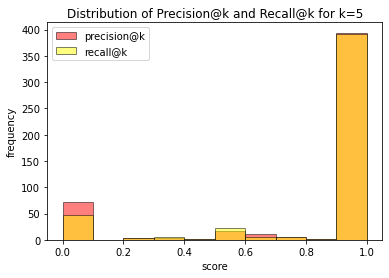

In [21]:
# plot the results
plt.hist(pre_at_k,alpha=0.5,edgecolor='black',label='precision@k',color='red')
plt.hist(rec_at_k,alpha=0.5,edgecolor='black',label='recall@k',color='yellow')
plt.title('Distribution of Precision@k and Recall@k for k=5')
plt.xlabel('score')
plt.ylabel('frequency')
plt.legend()
plt.show()

These results are quite encouraging: the mean and median results show that the top K=5 movie recommendations capture the clear majority of relevant movies in the test set. This conclusion is also supported by the histogram plot illustrating our results for individual users.

Note that there are ways we can try to improve the model. One point that could be tried is to enhance how the ratings dataframe is built from the output of the recommender. In this notebook, I computed the mean rating over the K most similar users. This does not take into account the relative degree of similarity these users have to the intended target user. You could try to extract the cosine similarity scores from the KNN instance, and use this to compute a weighted mean rating instead.